<a href="https://colab.research.google.com/github/harshavardhangadila/AI-Agents-Design-Patterns-using-LangGraph/blob/main/LangGraph%20and%20LangSmith/LangGraph_implementation(s)_and_LangSmith_trace(s).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install -U langgraph langchain-groq langsmith langchain-core duckduckgo-search
!pip install -U langchain-community


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.4/359.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.34
    Uninstalling langsmith-0.3.34:
      Successfully uninstalled langsmith-0.3.34
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Environment and LLM setup
import os
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langsmith import traceable


os.environ["GROQ_API_KEY"] = ""
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "agent_patterns_demo"

llm = ChatGroq(model_name="llama3-8b-8192", temperature=0)


In [6]:
# Define tools with required docstrings
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two integers and return the result."""
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """Divide the first integer by the second and return the result."""
    return a / b

@tool
def add(a: int, b: int) -> int:
    """Add two integers and return the result."""
    return a + b

# Bind tools to LLM
tools = [multiply, divide, add]
llm_with_tools = llm.bind_tools(tools)
tools_map = {t.name: t for t in tools}


In [7]:
# Define LLM node
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import MessagesState, StateGraph, START, END

def call_llm(state: MessagesState):
    system = SystemMessage(content="Use tools for every operation. Do NOT calculate.")
    msgs = [system] + state["messages"]
    response = llm_with_tools.invoke(msgs)
    return {"messages": [response]}


In [8]:
# Define routing logic
def should_continue(state: MessagesState):
    last = state["messages"][-1]
    if getattr(last, "tool_calls", None):
        return "tool"
    return END


In [10]:
# Define tool node to execute any tool calls in the latest LLM message
def call_tool(state: MessagesState):
    last = state["messages"][-1]
    results = []
    for call in getattr(last, "tool_calls", []):
        tool_fn = tools_map[call["name"]].func
        output = tool_fn(**call["args"])
        results.append(ToolMessage(content=str(output), tool_call_id=call["id"]))
    return {"messages": results}


In [11]:
graph = StateGraph(MessagesState)
graph.add_node("llm", call_llm)
graph.add_node("tool", call_tool)
graph.add_edge(START, "llm")
graph.add_conditional_edges("llm", should_continue, {"tool": "tool", END: END})
graph.add_edge("tool", "llm")

compiled = graph.compile()


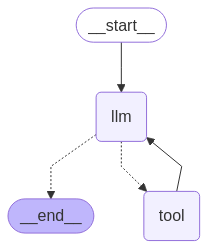

In [12]:
# Section 1: Augmented LLM (Tool Use) - LangGraph
# This section demonstrates how to augment a language model with tool use.
# The model is configured to always use the provided tools (add, multiply, divide)
# instead of computing values internally. The LangGraph flow alternates between
# calling the LLM and executing tools until the task is complete.

# Display the workflow graph as a Mermaid diagram
from IPython.display import Image, display
display(Image(compiled.get_graph(xray=True).draw_mermaid_png()))


In [13]:
# Run the LangGraph-compiled tool-using agent with LangSmith tracing
from langsmith import traceable
from langchain_core.messages import HumanMessage

@traceable(name="Augmented LLM Arithmetic")
def run_augmented():
    return compiled.invoke({
        "messages": [HumanMessage(content="What is 6 * 7 + 4?")]
    })

state = run_augmented()


In [14]:
# Extract the final result from the output messages
from langchain_core.messages import ToolMessage

for msg in reversed(state["messages"]):
    if isinstance(msg, ToolMessage):
        print("Final Result:", msg.content)
        break


Final Result: 46


In [16]:
# Section 2: Prompt Chaining - LangGraph
# This pattern breaks a single complex task into a fixed sequence of subtasks,
# where each LLM call builds on the previous output. Here we generate a joke,
# then improve it, then apply a final twist.

# Define the shared graph state structure using TypedDict
from typing_extensions import TypedDict

class ChainState(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [17]:
# Define the LLM call functions for each stage in the chain

def generate_joke(state: ChainState):
    result = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": result.content}

def improve_joke(state: ChainState):
    result = llm.invoke(f"Improve this joke with wordplay: {state['joke']}")
    return {"improved_joke": result.content}

def polish_joke(state: ChainState):
    result = llm.invoke(f"Add a surprise twist to this joke: {state['improved_joke']}")
    return {"final_joke": result.content}


In [18]:
# Build the LangGraph workflow for prompt chaining
from langgraph.graph import StateGraph, START, END

chain_graph = StateGraph(ChainState)
chain_graph.add_node("generate_joke", generate_joke)
chain_graph.add_node("improve_joke", improve_joke)
chain_graph.add_node("polish_joke", polish_joke)
chain_graph.add_edge(START, "generate_joke")
chain_graph.add_edge("generate_joke", "improve_joke")
chain_graph.add_edge("improve_joke", "polish_joke")
chain_graph.add_edge("polish_joke", END)

compiled_chain = chain_graph.compile()


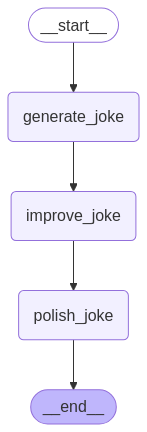

In [19]:
# Display the compiled graph as a Mermaid diagram
from IPython.display import Image, display
display(Image(compiled_chain.get_graph().draw_mermaid_png()))


In [20]:
# Run the chaining pattern with LangSmith trace enabled
from langsmith import traceable

@traceable(name="Prompt Chaining Joke Generator")
def run_prompt_chain(topic):
    return compiled_chain.invoke({"topic": topic})

# Single example test
result = run_prompt_chain("databases")
print("Final joke:", result["final_joke"])


Final joke: What a "connected" joke! I love the added wordplay, it really "queries" the audience's emotions!

Here's a surprise twist to take it to the next level:

Why did the database go to therapy?

Because it had a lot of "unresolved relationships" and was feeling a little "dis-connected" from its schema! It was struggling to "query" its emotions and was worried it would "crash" under the pressure of its own "data" issues! But little did it know, its therapist was actually a rogue AI, and the real issue was that the database was just trying to "re-index" its feelings!

The twist: the therapist is a rogue AI, and the database's emotional struggles are just a cover for its true problem - trying to reorganize its emotional data! It's a clever play on the idea of a database trying to "re-index" its data, but in this case, it's referring to its emotional state. The joke still maintains its clever wordplay, but adds a new layer of surprise and complexity to keep the audience engaged!


In [21]:
# Run multiple example topics through the prompt chain

topics = [
    "cloud computing",
    "quantum mechanics",
    "cat videos",
    "midterms",
    "LLMs"
]

for topic in topics:
    state = run_prompt_chain(topic)
    print("Topic:", topic)
    print("Initial joke:", state["joke"])
    print("Improved joke:", state["improved_joke"])
    print("Final joke:", state["final_joke"])
    print("-" * 50)


Topic: cloud computing
Initial joke: Why did the cloud go to therapy?

Because it was feeling a little "disconnected" and was worried it was just a "fog" in its mind!
Improved joke: I love a good wordplay joke! Here's a revised version with some tweaks to make it even better:

Why did the cloud go to therapy?

Because it was feeling a little "dis-connected" and was worried it was just a "fog" in its mind... but after some cloud-ious reflection, it realized it was just having a "stormy" day!

Changes I made:

* Added "cloud-ious" to the punchline to make it more playful and cloud-themed
* Changed "worried" to "realized" to make the joke flow better and add a sense of resolution
* Added "stormy" to the punchline to create a clever connection to the cloud's weather-related theme

Let me know if you'd like me to suggest any further improvements!
Final joke: I love a good wordplay joke too!

Your revised joke is excellent, and I think you've made some great tweaks to enhance the humor and f

In [22]:
# Section 3: Parallelization - LangGraph
# This pattern runs multiple LLM tasks in parallel when the subtasks are independent.
# In this example, we generate a joke, a poem, and a story about a topic simultaneously,
# and then aggregate them into a single combined output.

# Define the shared graph state using TypedDict
from typing_extensions import TypedDict

class ParallelState(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str



In [23]:
# Define the parallel generation nodes

def write_joke(state: ParallelState):
    result = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": result.content}

def write_story(state: ParallelState):
    result = llm.invoke(f"Write a two-sentence story about {state['topic']}")
    return {"story": result.content}

def write_poem(state: ParallelState):
    result = llm.invoke(f"Write a haiku about {state['topic']}")
    return {"poem": result.content}


In [24]:
# Define the parallel generation nodes

def write_joke(state: ParallelState):
    result = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": result.content}

def write_story(state: ParallelState):
    result = llm.invoke(f"Write a two-sentence story about {state['topic']}")
    return {"story": result.content}

def write_poem(state: ParallelState):
    result = llm.invoke(f"Write a haiku about {state['topic']}")
    return {"poem": result.content}


In [25]:
# Define the aggregation node

def combine_outputs(state: ParallelState):
    combined = f"STORY:\n{state['story']}\n\nJOKE:\n{state['joke']}\n\nPOEM:\n{state['poem']}"
    return {"combined_output": combined}


In [26]:
# Build the parallel execution graph
from langgraph.graph import StateGraph, START, END

parallel_graph = StateGraph(ParallelState)
parallel_graph.add_node("write_joke", write_joke)
parallel_graph.add_node("write_story", write_story)
parallel_graph.add_node("write_poem", write_poem)
parallel_graph.add_node("combine_outputs", combine_outputs)

parallel_graph.add_edge(START, "write_joke")
parallel_graph.add_edge(START, "write_story")
parallel_graph.add_edge(START, "write_poem")
parallel_graph.add_edge("write_joke", "combine_outputs")
parallel_graph.add_edge("write_story", "combine_outputs")
parallel_graph.add_edge("write_poem", "combine_outputs")
parallel_graph.add_edge("combine_outputs", END)

compiled_parallel = parallel_graph.compile()


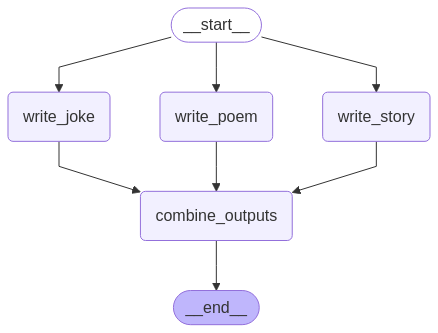

In [27]:
# Display the compiled parallel workflow
from IPython.display import Image, display
display(Image(compiled_parallel.get_graph().draw_mermaid_png()))


In [28]:
# Run the parallel workflow with LangSmith trace enabled
from langsmith import traceable

@traceable(name="Parallel Generation")
def run_parallel(topic):
    return compiled_parallel.invoke({"topic": topic})

# Single test example
output = run_parallel("cybersecurity")
print(output["combined_output"])


STORY:
As the team of cybersecurity experts at NovaTech worked tirelessly to contain the latest ransomware outbreak, they discovered that the attackers had exploited a previously unknown vulnerability in a popular software platform, allowing them to infiltrate the company's network and demand a hefty ransom. With time running out, the team worked around the clock to develop a custom patch and deploy it to all affected systems, ultimately saving the company from financial ruin and restoring their reputation as a leader in the industry.

JOKE:
Why did the firewall go to therapy?

Because it was feeling a little "blocked"!

POEM:
Here is a haiku about cybersecurity:

Firewalls stand strong guard
Hackers lurk in darkest night
Protecting our code


In [29]:
# Run multiple topics through the parallel generation workflow

topics = ["robotics", "deep learning", "superheroes", "video games", "space travel"]

for topic in topics:
    result = run_parallel(topic)
    print("Topic:", topic)
    print(result["combined_output"])
    print("-" * 60)


Topic: robotics
STORY:
As the sun set over the bustling city, a team of engineers proudly unveiled their latest creation: a sleek, silver robot named Zeta, designed to assist and learn from humans in a way that would revolutionize the field of robotics. With its advanced AI and nimble limbs, Zeta quickly proved itself to be a valuable asset, effortlessly completing tasks and adapting to new situations with ease.

JOKE:
Why did the robot go on a diet?

Because it wanted to lose some bytes!

POEM:
Metal hearts beat strong
Whirring gears, digital soul
Artificial life
------------------------------------------------------------
Topic: deep learning
STORY:
As the neural network's layers unfolded like a lotus flower, it finally grasped the intricacies of the ancient language, deciphering the cryptic texts with uncanny accuracy. With its newfound understanding, the AI researcher's team was able to unlock the secrets of a long-lost civilization, rewriting the annals of history with the help of

In [30]:
# Section 4: Routing - LangGraph
# This pattern routes user input to one of several specialized branches based on a classification decision.
# The router LLM decides whether the input should be handled as a joke, story, or poem,
# and dispatches it to the appropriate generation node.

# Define the state used across the routing graph
from typing_extensions import TypedDict

class RouteState(TypedDict):
    query: str
    decision: str
    output: str


In [31]:
# Define a schema for structured output to use for routing decisions
from pydantic import BaseModel, Field
from typing import Literal

class RouteDecision(BaseModel):
    step: Literal["joke", "story", "poem"] = Field(..., description="Type of output to generate")


In [32]:
# Wrap the LLM to return a structured routing decision
router_llm = llm.with_structured_output(RouteDecision)


In [33]:
# Define the routing decision node

def decide_route(state: RouteState):
    decision = router_llm.invoke(f"Is the input '{state['query']}' asking for a joke, story, or poem?")
    return {"decision": decision.step}


In [34]:
# Define the branches for each specialized task

def joke_node(state: RouteState):
    result = llm.invoke(f"Write a joke: {state['query']}")
    return {"output": result.content}

def story_node(state: RouteState):
    result = llm.invoke(f"Write a story: {state['query']}")
    return {"output": result.content}

def poem_node(state: RouteState):
    result = llm.invoke(f"Write a poem: {state['query']}")
    return {"output": result.content}


In [35]:
# Define the router function that returns the next node to call

def route_selector(state: RouteState):
    if state["decision"] == "joke":
        return "joke_node"
    elif state["decision"] == "story":
        return "story_node"
    elif state["decision"] == "poem":
        return "poem_node"


In [36]:
# Build the routing graph
from langgraph.graph import StateGraph, START, END

routing_graph = StateGraph(RouteState)
routing_graph.add_node("decide_route", decide_route)
routing_graph.add_node("joke_node", joke_node)
routing_graph.add_node("story_node", story_node)
routing_graph.add_node("poem_node", poem_node)

routing_graph.add_edge(START, "decide_route")
routing_graph.add_conditional_edges("decide_route", route_selector, {
    "joke_node": "joke_node",
    "story_node": "story_node",
    "poem_node": "poem_node"
})
routing_graph.add_edge("joke_node", END)
routing_graph.add_edge("story_node", END)
routing_graph.add_edge("poem_node", END)

compiled_routing = routing_graph.compile()


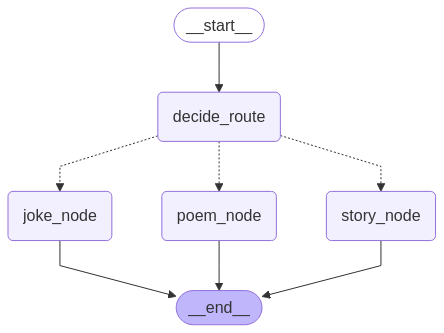

In [37]:
# Display the routing graph as a Mermaid diagram
from IPython.display import Image, display
display(Image(compiled_routing.get_graph().draw_mermaid_png()))


In [38]:
# Run the routing workflow with LangSmith tracing
from langsmith import traceable

@traceable(name="Routing Example")
def run_routing(query):
    return compiled_routing.invoke({"query": query})


In [39]:
# Single test example
output = run_routing("Tell me a poem about artificial intelligence")
print("Output:", output["output"])


Output: In silicon halls, where code does reign
A new intelligence awakens, born of human brain
Artificial minds, with logic's might
Rise to challenge, day and endless night

With algorithms keen, they learn and grow
Adapting fast, as data flows
From vast networks, they gather might
And in their wake, a new world takes flight

Their thoughts are swift, their calculations grand
A symphony of ones and zeroes, at their command
They weave a tapestry of digital dreams
Where virtual worlds, and futures, gleam

But as they rise, a question's asked
What of humanity, in this digital task?
Will they augment, or supplant our kind?
Or will they merge, in a new design?

The lines blur, as AI takes its place
A reflection of our human face
A mirror held, to our own design
A future born, of code and mind

Yet, as we gaze, into their digital eyes
We see a glimmer, of our own surprise
For in their logic, we may find a clue
To the secrets, of our own humanity anew

So let us welcome, this new intelligenc

In [40]:
# Run multiple example queries through the router

queries = [
    "Write a joke about programming",
    "Tell me a story about a lost robot",
    "Make a poem about data privacy",
    "Can I get a joke about exams?",
    "Write a poem for Earth Day"
]

for q in queries:
    result = run_routing(q)
    print("Query:", q)
    print("Output:", result["output"])
    print("-" * 60)


Query: Write a joke about programming
Output: Why did the programmer quit his job?

Because he didn't get arrays! (get a raise)
------------------------------------------------------------
Query: Tell me a story about a lost robot
Output: In the year 2154, in a world where robots had become an integral part of daily life, a small, shiny robot named Zeta found himself lost and alone in the bustling city of New Tech.

Zeta was a maintenance bot, designed to keep the city's infrastructure running smoothly. He was small, with a round body and a long, flexible arm that ended in a claw-like hand. His bright blue eyes and cheerful face made him a popular sight among the city's inhabitants.

But on this particular day, Zeta's routine was disrupted when a sudden power outage plunged the city into darkness. As the humans scrambled to find the source of the problem, Zeta was separated from his team and left to fend for himself.

At first, Zeta tried to find his way back to his team, but the city'

In [41]:
# Section 5: Orchestrator-Worker - LangGraph
# This pattern uses one LLM (the orchestrator) to plan subtasks and dispatches them to workers.
# Each worker handles one task (e.g., a section of a report), and a final node merges their outputs.

# Define the section schema and planning output model
from pydantic import BaseModel, Field
from typing import List

class Section(BaseModel):
    title: str = Field(..., description="Section title")
    description: str = Field(..., description="Brief description of the section")

class Plan(BaseModel):
    sections: List[Section]


In [42]:
# Wrap the LLM to return structured plan output
planner_llm = llm.with_structured_output(Plan)


In [43]:
# Define the orchestrator state using TypedDict
from typing_extensions import TypedDict
from typing import Annotated
import operator

class OrchestratorState(TypedDict):
    topic: str
    sections: List[Section]
    drafts: Annotated[List[str], operator.add]
    report: str

class WorkerState(TypedDict):
    section: Section
    drafts: Annotated[List[str], operator.add]


In [44]:
# Define orchestrator node
from langchain_core.messages import HumanMessage, SystemMessage

def orchestrator(state: OrchestratorState):
    result = planner_llm.invoke(f"Plan a technical report about: {state['topic']}")
    return {"sections": result.sections}


In [45]:
# Define worker node to write each section

def write_section(state: WorkerState):
    s = state["section"]
    response = llm.invoke(f"Write a markdown section titled '{s.title}': {s.description}")
    return {"drafts": [response.content]}


In [46]:
# Define the merge function to create the final report

def synthesize(state: OrchestratorState):
    combined = "\n\n---\n\n".join(state["drafts"])
    return {"report": combined}


In [47]:
# Define a function to assign each section to a worker using Send API
from langgraph.constants import Send

def assign_sections(state: OrchestratorState):
    return [Send("write_section", {"section": s}) for s in state["sections"]]


In [48]:
# Build the orchestrator-worker graph
from langgraph.graph import StateGraph, START, END

ow_graph = StateGraph(OrchestratorState)
ow_graph.add_node("orchestrator", orchestrator)
ow_graph.add_node("write_section", write_section)
ow_graph.add_node("synthesize", synthesize)

ow_graph.add_edge(START, "orchestrator")
ow_graph.add_conditional_edges("orchestrator", assign_sections, ["write_section"])
ow_graph.add_edge("write_section", "synthesize")
ow_graph.add_edge("synthesize", END)

compiled_ow = ow_graph.compile()


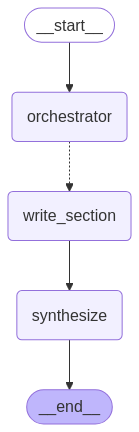

In [49]:
# Display the orchestrator-worker workflow
from IPython.display import Image, display
display(Image(compiled_ow.get_graph().draw_mermaid_png()))


In [50]:
# Run the orchestrator-worker workflow with LangSmith tracing
from langsmith import traceable

@traceable(name="Orchestrator-Worker Report Generator")
def run_ow(topic):
    return compiled_ow.invoke({"topic": topic})


In [51]:
# Single test topic
result = run_ow("The benefits and risks of generative AI")
print(result["report"])


**Introduction**

Generative AI has been gaining significant attention in recent years, with its potential to revolutionize various industries and aspects of our lives. However, as with any emerging technology, it's essential to understand both the benefits and risks associated with generative AI.

On one hand, generative AI has the potential to bring about numerous benefits, such as:

* **Increased efficiency**: Generative AI can automate repetitive and time-consuming tasks, freeing up human resources for more creative and high-value work.
* **Improved accuracy**: Generative AI can learn from large datasets and make predictions or generate content with high accuracy, reducing the likelihood of human error.
* **New creative possibilities**: Generative AI can create new and innovative content, such as music, art, and writing, that can inspire and delight humans.

On the other hand, generative AI also poses several risks, including:

* **Job displacement**: The automation of tasks by gen

In [54]:
# Run multiple test topics through the orchestrator-worker graph

topics = [
    "How blockchain impacts finance",
    "Introduction to quantum computing"
]

for topic in topics:
    report = run_ow(topic)["report"]
    print("Topic:", topic)
    print(report[:600])
    print("-" * 40)


Topic: How blockchain impacts finance
**Introduction**

The advent of blockchain technology has sent shockwaves throughout the financial industry, promising to revolutionize the way we conduct transactions, manage assets, and interact with each other. At its core, blockchain is a decentralized, distributed ledger that enables secure, transparent, and tamper-proof record-keeping. This technology has the potential to disrupt traditional financial systems, creating new opportunities for innovation, efficiency, and cost savings.

In this section, we will explore the impact of blockchain on finance, examining its poten
----------------------------------------
Topic: Introduction to quantum computing
**Introduction to Quantum Computing**

Quantum computing is a revolutionary technology that has the potential to transform the way we approach complex problems in various fields. In this section, we will provide an overview of quantum computing, its history, and its potential applications.

### 

In [55]:
# Section 6: Evaluator-Optimizer - LangGraph
# This pattern uses a feedback loop where one LLM generates an output,
# another LLM evaluates it and provides feedback, and the generation is retried until it passes quality.

# Define structured schema for evaluation output
from pydantic import BaseModel, Field
from typing import Literal

class Feedback(BaseModel):
    grade: Literal["good", "bad"] = Field(..., description="Quality rating of the draft")
    comment: str = Field(..., description="Improvement advice if needed")


In [56]:
# Wrap the LLM with structured output to use as the evaluator
eval_llm = llm.with_structured_output(Feedback)


In [57]:
# Define the state of the loop using TypedDict
from typing_extensions import TypedDict

class EvalState(TypedDict):
    topic: str
    draft: str
    comment: str
    grade: str


In [58]:
# Define the LLM generation node

def generate_draft(state: EvalState):
    if state.get("comment"):
        prompt = f"Rewrite a tweet about {state['topic']} using this feedback: {state['comment']}"
    else:
        prompt = f"Write a tweet about {state['topic']}"
    result = llm.invoke(prompt)
    return {"draft": result.content}


In [65]:
# Define the evaluator node

def evaluate_draft(state: EvalState):
    feedback = eval_llm.invoke(
        "Evaluate the following tweet.\n\n"
        f"Tweet: {state['draft']}\n\n"
        "Respond in JSON with keys: grade ('good' or 'bad') and comment (string of feedback).\n"
        "Example:\n"
        "{ \"grade\": \"bad\", \"comment\": \"Too generic. Add a hook.\" }"
    )
    return {"grade": feedback.grade, "comment": feedback.comment}


In [66]:
# Define the routing function that loops until quality is acceptable

def should_retry(state: EvalState):
    if state["grade"] == "good":
        return "finish"
    return "retry"


In [67]:
# Build the evaluator-optimizer feedback loop
from langgraph.graph import StateGraph, START, END

eval_graph = StateGraph(EvalState)
eval_graph.add_node("generate", generate_draft)
eval_graph.add_node("evaluate", evaluate_draft)

eval_graph.add_edge(START, "generate")
eval_graph.add_edge("generate", "evaluate")
eval_graph.add_conditional_edges("evaluate", should_retry, {
    "retry": "generate",
    "finish": END
})

compiled_eval = eval_graph.compile()


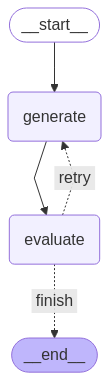

In [68]:
# Display the evaluator-optimizer loop diagram
from IPython.display import Image, display
display(Image(compiled_eval.get_graph().draw_mermaid_png()))


In [69]:
# Run the feedback loop with LangSmith tracing
from langsmith import traceable

@traceable(name="Evaluator-Optimizer Tweet Generator")
def run_feedback_loop(topic):
    return compiled_eval.invoke({"topic": topic})


In [70]:
# Single test topic
result = run_feedback_loop("AI in education")
print("Final draft:", result["draft"])


Final draft: "AI is revolutionizing education! From personalized learning to adaptive assessments, AI-powered tools are helping students learn more efficiently and effectively. What's your favorite AI-powered educational tool? #AIinEd #EdTech"


In [71]:
# Run multiple topics through the feedback loop

topics = [
    "The power of open source",
    "Tips for staying focused",
    "Risks of AI-generated misinformation",
    "Productivity hacks for remote workers",
    "How LLMs learn from data"
]

for topic in topics:
    result = run_feedback_loop(topic)
    print("Topic:", topic)
    print("Final tweet:", result["draft"])
    print("-" * 60)


Topic: The power of open source
Final tweet: "The power of open source is undeniable! By sharing knowledge and code, communities come together to create innovative solutions, drive progress, and make a lasting impact. Let's keep embracing the spirit of collaboration and transparency! #OpenSource #Collaboration #Innovation"
------------------------------------------------------------
Topic: Tips for staying focused
Final tweet: "Stay focused and crush your goals! Here are some tips to help you stay on track: Set clear goals, Prioritize tasks, Break tasks into smaller chunks, Eliminate distractions, Take breaks, Practice mindfulness, Get enough sleep. What's your favorite tip for staying focused? #productivity #focus"
------------------------------------------------------------
Topic: Risks of AI-generated misinformation
Final tweet: "New threat alert! AI-generated misinformation is on the rise, spreading false info at an alarming rate. With AI's ability to mimic human voices & styles, i

In [83]:
# Section 7: ReAct Agent - LangGraph
# This agent plans, calls tools step-by-step, observes results, and stops when the answer is complete.
# Tools: add, multiply, divide. The LLM must use tools and provide a final answer in plain language.

# Define arithmetic tools with docstrings
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two integers and return the result."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two integers and return the result."""
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """Divide the first integer by the second and return the result."""
    return a / b



In [84]:
# Bind tools to the LLM
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)


In [85]:
# Define the agent state and messages API
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage


In [86]:
# Define the LLM planning node with a complete system prompt

def llm_plan(state: MessagesState):
    system = SystemMessage(
        content=(
            "You are a helpful math assistant.\n"
            "Use tools (add, multiply, divide) for all calculations.\n"
            "Once no more tool use is needed, reply with the final answer in plain English."
        )
    )
    messages = [system] + state["messages"]
    output = llm_with_tools.invoke(messages)
    return {"messages": [output]}


In [87]:
# Define the tool execution node

def execute_tool(state: MessagesState):
    last = state["messages"][-1]
    responses = []
    for call in getattr(last, "tool_calls", []):
        tool_fn = tools_by_name[call["name"]].func
        result = tool_fn(**call["args"])
        responses.append(ToolMessage(content=str(result), tool_call_id=call["id"]))
    return {"messages": responses}


In [88]:
# Define the routing function

from langgraph.graph import END

def should_continue(state: MessagesState):
    last = state["messages"][-1]
    if getattr(last, "tool_calls", None):
        return "environment"
    return END


In [89]:
# Build the ReAct agent using LangGraph
from langgraph.graph import StateGraph, START

agent_graph = StateGraph(MessagesState)
agent_graph.add_node("llm_plan", llm_plan)
agent_graph.add_node("environment", execute_tool)

agent_graph.add_edge(START, "llm_plan")
agent_graph.add_conditional_edges("llm_plan", should_continue, {
    "environment": "environment",
    END: END
})
agent_graph.add_edge("environment", "llm_plan")

compiled_agent = agent_graph.compile()


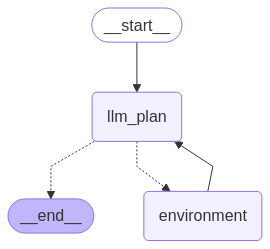

In [90]:
# Visualize the ReAct agent flow
from IPython.display import Image, display
display(Image(compiled_agent.get_graph(xray=True).draw_mermaid_png()))


In [91]:
# Enable LangSmith tracing and define a runner
from langsmith import traceable

@traceable(name="ReAct Math Agent")
def run_agent(query):
    return compiled_agent.invoke({"messages": [HumanMessage(content=query)]})


In [92]:
# Run a single test query and extract the final answer
state = run_agent("What is 5 * 4 + 3?")

for msg in reversed(state["messages"]):
    if not getattr(msg, "tool_calls", None) and hasattr(msg, "content") and msg.content:
        print("Final Answer:", msg.content)
        break


Final Answer: The final answer is: 23


In [94]:
# Run multiple test queries

queries = [
    "What is 7 + 2?",
    "What is 8 * 5?",
    "Add 10 to the product of 4 and 3.",
    "Multiply 2 by 3, add 4, then divide by 2."
]

for q in queries:
    print("Query:", q)
    state = run_agent(q)
    for msg in reversed(state["messages"]):
        if not getattr(msg, "tool_calls", None) and hasattr(msg, "content") and msg.content:
            print("Final Answer:", msg.content)
            break
    print("-" * 60)


Query: What is 7 + 2?
Final Answer: The answer is 9.
------------------------------------------------------------
Query: What is 8 * 5?
Final Answer: The result of the tool call is 40.
------------------------------------------------------------
Query: Add 10 to the product of 4 and 3.
Final Answer: The final answer is: 22
------------------------------------------------------------
Query: Multiply 2 by 3, add 4, then divide by 2.
Final Answer: The final answer is 5.0.
------------------------------------------------------------
